# Bayesian inference 
Bayesian inference for PCFGs via MCMC. We implement a Gibs sampler and a Metropolis-Hastings sampler.

We follow Johnson et al. (2007) "Bayesian Inference for PCFGs via Markov chain Monte Carlo". 

In [196]:
from rule import Rule
from cfg import WCFG, read_grammar_rules
from parser import cky
from earley import earley
from symbol import make_symbol, is_nonterminal, is_terminal
import numpy as np
from collections import defaultdict
from InsideOutside import inside, outside, inside_outside, EM, plot_EM
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
# We use the ambiguous grammar
G = WCFG(read_grammar_rules(open('examples/ambiguous', 'r')))
print G

[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


# Generate a sample corpora from a PCFG

Again we generate a corpus from the pcfg.

In [188]:
def generate_sample(grammar, items=('[E]',)):
    """
    Given a grammar returns a sentence from it using
    the probabilities specfied in the grammar.
    :param items: call the function with (start,) where 
                  start is the start symbol of the grammar
    :returns: a sentence from the language as a list
    """
    frags = []
    for item in items:
        if is_nonterminal(item):
            productions = grammar.get(item)
            ps = [production.prob for production in productions]
            random_index = np.argmax(np.random.multinomial(1, ps, size=1))
            prod = productions[random_index]
            frags.extend(generate_sample(grammar, items=prod.rhs))
        else:
            frags.append(item)
    return frags

def generate_corpus(grammar, n, start=('[E]',)):
    """
    Generates a corpus using the grammar
    :param n: size of the corpus
    :params: same a s generate corpus
    :returns: a corpus in the form of a list
    """
    return [generate_sample(grammar, items=start) for i in range(n)]

def initialize(grammar, alpha=20.0):
    """
    Takes a grammar and returns that grammar with 
    the probabilities replaced by random probabilities
    generated from a Dirichlet distribution.
    :param: alpha is the Dirichlet concentration parameter
    """
    init_grammar = WCFG()
    for nonterminal in grammar.nonterminals:
        rules = grammar.get(nonterminal)
        init_prob = np.random.dirichlet(len(rules)*[alpha])
        for i, rule in enumerate(rules):
            init_grammar.add(Rule(rule.lhs, rule.rhs, init_prob[i]))
    return init_grammar

In [180]:
corpus1 = generate_corpus(G, 10)
corpus2 = generate_corpus(G, 100)
corpus3 = generate_corpus(G, 1000)

print corpus1

[['a', '+', 'a'], ['a'], ['a', '*', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a', '+', 'a', '*', 'a'], ['a', '+', 'a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a', '+', 'a', '*', 'a'], ['a'], ['a', '*', 'a'], ['a', '*', 'a', '+', 'a', '+', 'a'], ['a', '+', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a', '*', 'a'], ['a']]


In [5]:
sentence = corpus1[1]
cky_forest = cky(G, sentence)
print cky_forest

[E:2-9] -> [E:2-7] * [T:8-9] (0.05)
[E:2-9] -> [E:2-5] + [T:6-9] (0.45)
[E:2-9] -> [T:2-9] (0.5)
[E:2-9] -> [E:2-3] * [T:4-9] (0.05)
[T:2-7] -> [T:2-5] + [P:6-7] (0.1)
[E:2-5] -> [E:2-3] * [T:4-5] (0.05)
[E:2-5] -> [T:2-5] (0.5)
[T:2-9] -> [T:2-7] * [P:8-9] (0.4)
[E:0-9] -> [T:0-9] (0.5)
[E:0-9] -> [E:0-1] + [T:2-9] (0.45)
[E:0-9] -> [E:0-7] * [T:8-9] (0.05)
[E:0-9] -> [E:0-5] + [T:6-9] (0.45)
[E:0-9] -> [E:0-3] * [T:4-9] (0.05)
[T:0-11] -> [T:0-9] * [P:10-11] (0.4)
[P:0-1] -> a (1.0)
[E:0-11] -> [E:0-9] * [T:10-11] (0.05)
[E:0-11] -> [E:0-5] + [T:6-11] (0.45)
[E:0-11] -> [E:0-3] * [T:4-11] (0.05)
[E:0-11] -> [T:0-11] (0.5)
[E:0-11] -> [E:0-1] + [T:2-11] (0.45)
[E:0-11] -> [E:0-7] * [T:8-11] (0.05)
[E:0-7] -> [E:0-1] + [T:2-7] (0.45)
[E:0-7] -> [E:0-5] + [T:6-7] (0.45)
[E:0-7] -> [E:0-3] * [T:4-7] (0.05)
[E:0-7] -> [T:0-7] (0.5)
[T:8-11] -> [T:8-9] * [P:10-11] (0.4)
[T:10-11] -> [P:10-11] (0.5)
[T:0-3] -> [T:0-1] + [P:2-3] (0.1)
[T:0-5] -> [T:0-3] * [P:4-5] (0.4)
[T:0-1] -> [P:0-1] (0.

# Ancestral sampler

[Author: Wilker]

Often we are interested in drawing random samples from the distribution p(t|x).

We can do that by sampling from the inverted CDF associated with p(t|x).
The conditional independence assumption central to PCFGs make them convenient for sampling by *ancestral sampling*.

The code below is very similar to the Viterbi code above, however, instead of maximising at each step, we draw a random edge from the distribution defined by their inside weights. 

In [6]:
from collections import deque
import random
def ancestral_sample(forest, I, start):
    """
    Author: Wilker Aziz
    Taken from lab-inference.ipynb
    """
    Q = deque([start])
    d = []
    while Q:
        parent = Q.popleft()
        incoming = forest.get(parent)
        # here we compute the distribution over edges
        weights = [0.0] * len(incoming)
        for i, rule in enumerate(incoming):
            weights[i] = rule.prob
            for child in rule.rhs:
                weights[i] *= I[child]
        # here we draw a random threshold (think of it as sampling from the inverted CDF)
        th = random.uniform(0, I[parent])
        # here we compute the CDF step by step and check
        # for which edge e whether cdf(e) > th
        total = 0.0
        selected = None
        back = None
        for w, rule in zip(weights, incoming):
            total += w
            if total > th:
                selected = rule
                break
            else:
                back = rule
        if selected is None:  # this is to deal with corner cases due to rounding problems
            selected = back
        # every nonterminal child of the selected edge must be added to the queue
        for sym in selected.rhs:
            if is_nonterminal(sym):
                Q.append(sym)
        d.append(selected)
    return d

In [7]:
goal = make_symbol('[E]', 0, len(sentence))
I = inside(cky_forest, goal)

ancestral_sample(cky_forest, I, goal)

[[E:0-11] -> [E:0-5] + [T:6-11] (0.45),
 [E:0-5] -> [E:0-1] + [T:2-5] (0.45),
 [T:6-11] -> [T:6-9] * [P:10-11] (0.4),
 [E:0-1] -> [T:0-1] (0.5),
 [T:2-5] -> [T:2-3] * [P:4-5] (0.4),
 [T:6-9] -> [T:6-7] * [P:8-9] (0.4),
 [P:10-11] -> a (1.0),
 [T:0-1] -> [P:0-1] (0.5),
 [T:2-3] -> [P:2-3] (0.5),
 [P:4-5] -> a (1.0),
 [T:6-7] -> [P:6-7] (0.5),
 [P:8-9] -> a (1.0),
 [P:0-1] -> a (1.0),
 [P:2-3] -> a (1.0),
 [P:6-7] -> a (1.0)]

# Gibs sampler
A Gibs sampler for Bayesian inference on the ambiguous grammar with Dirichlet prior. We alternatingly sample from (1) and (2).

$
\begin{align}
\text{P}(\textbf{t} \mid \theta, \textbf{w}) &= \prod_{i=1}^{n}\text{P}(t_i \mid w_i, \theta)
\end{align}\\
$

This means for each string of terminals (sentence) $w_i$ we can sample one tree $t_i$ from the grammar $G$ that has production probabilities given by $\theta$.

$
\begin{align}
\text{P}(\theta\mid\textbf{t}, \textbf{w}, \alpha) &= \text{P}_D(\theta\mid\textbf{f}(\textbf{t}) + \alpha) \\
&= \prod_{A\in N}\text{P}_D(\theta_A\mid\textbf{f}_A(\textbf{t}) + \alpha_A)
\end{align}\\
$

This means that we can sample each $\theta_A$ independently from a Dirichlet($\textbf{f}_A(\textbf{t}) + \alpha_A$). Here, $\textbf{f}(\textbf{t})$ is the vector of production counts in the set of trees $\textbf{t}$ indexed by productions $r\in R$ and $\textbf{f}_A(\textbf{t})$ the component subvector of $\textbf{f}(\textbf{t})$ of production counts in $\textbf{t}$ indexed by $r \in R_A$.

### Helper functions for the Gibs sampler

In [74]:
def get_instances(rule, forest):
    """
    Given a rule
    
    A -> B C 
    
    get_instances collects all instances of rules of the form
    
    [A:i-j] -> [B:i-k] [C:k-j] 
    
    from the forest and returns them in a list.
    """
    instances = []
    for r in forest:
        if r.lhs[1] == rule.lhs[1] and len(r.rhs)==len(rule.rhs):
            test = []
            for i in range(len(r.rhs)):
                try:
                    # if for example r.rhs[i] = '[A]' 
                    v = r.rhs[i][1] == rule.rhs[i][1]
                    test.append(v)
                except IndexError:
                    # if for example r.rhs[i] = '*' 
                    v = r.rhs[i][0] == rule.rhs[i][0]
                    test.append(v)
            if np.all(test):
                instances.append(r)
    return instances

def sample_thetas(grammar, alphas):
    """
    :param alphas: a dictionary with dictionaries. Nonterminal A as key. As values 
    a dictionary with rules R that start with nonerminal A as keys and the alpha_R 
    Dirichlet pseudocounts as value:
    
    alphas = {A: {A -> B C: alpha_{A -> B C}, A -> a: alpha_{A -> a}}, 
              B: {B -> b: alpha_{A -> B C},...},
              ...}
    
    :returns: thetas drawn from a Dirichlet(alpha_A) for each nonerminal A in the same format as alphas.
    """
    thetas = {}
    # for each A we sample theta_A independently
    for A in grammar.nonterminals:
        R_A = grammar.get(A)
        alpha_A = [alphas[A][R] for R in R_A]
        theta_A = np.random.dirichlet(alpha_A)
        thetas[A] = {R: theta_A[i] for i, R in enumerate(R_A)}
    return thetas

def update_grammar(grammar, thetas):
    """
    :param G: a WCFG grammar
    :param thetas: thetas_A for all nonterminals A in G in the (peculiar) format 
    as returned by sample_thetas
    :returns: a WCFG new_G with the old thetas replaced by the new thetas
    """
    new_grammar = WCFG()
    for A in grammar.nonterminals:
        for rule, new_theta in thetas[A].iteritems():
            new_grammar.add(Rule(rule.lhs, rule.rhs, new_theta))
    return new_grammar

def update_alphas(alphas, grammar, tree, alpha_udpate_frac):
    for A in grammar.nonterminals:
        for rule in alphas[A]:
            # see explanation for function of alpha_udpate_frac
            alphas[A][rule] += len(get_instances(rule, tree))/float(alpha_udpate_frac)
    return alphas

def make_samples(grammar, corpus):
    samples = []
    for sentence in corpus:
        goal = make_symbol('[E]', 0, len(sentence))
        forest = cky(grammar, sentence)
        I = inside(forest, goal)
        samples.append(ancestral_sample(forest, I, goal))
    return samples

## The sampler

In [161]:
def gibs_sample(n, grammar, corpus, alpha=1, alpha_udpate_frac=1., plot_len=100):
    samples_dict = defaultdict(list)
    # saving the correct probs of the grammar
    none_grammar = WCFG()
    for rule in grammar:
            ruled = Rule(rule.lhs, rule.rhs, None) # prob=None so we can find the rules
            none_grammar.add(ruled)
            samples_dict[ruled].append(rule.prob)  # in the dict even as probs change
    
    alphas = {A: {R: alpha for R in none_grammar.get(A)} for A in none_grammar.nonterminals}
    
    for i in range(n):
        # sample p(theta|t,w,alpha)
        thetas = sample_thetas(none_grammar, alphas)
        # update G with these thetas
        new_grammar = update_grammar(grammar, thetas) 

        # sample p(t|theta,w,alpha)
        samples = make_samples(new_grammar, corpus) # for each w_i in the corpus sample one t_i based on new_grammar
        
        # saving thetas per rule
        for rule in new_grammar:
            ruled = Rule(rule.lhs, rule.rhs, None)
            samples_dict[ruled].append(rule.prob)
        
        # NEW: re-set alphas for each run
        alphas = {A: {R: alpha for R in none_grammar.get(A)} for A in none_grammar.nonterminals}
        # update alpha with rule counts
        for tree in samples:
            new_alphas = update_alphas(alphas, grammar, tree,
                                       alpha_udpate_frac)   # need not use new_grammar here: probs play no roles
                                                            # grammar only needed to get rules by nonerminals
        grammar = new_grammar
        alphas = new_alphas
#         print alphas
#         print '\n'
    
    # for plotting 
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    i = 0
    for rule, prob in samples_dict.iteritems():
        # plot correct values with ---
        plt.plot(range(n-plot_len,n+1), [prob[0]]*(plot_len+1), '--', color=colors[i], )
        # plot gibs sample-path with solid line
        plt.plot(range(n-plot_len,n+1), prob[n-plot_len:], color=colors[i])
        i += 1
    
    plt.show()
    plt.clf()
    
    return new_grammar, alphas, samples_dict

## A note on $\alpha$

In the model, we specified a hyperparameter $\alpha_A$ controlling the Dirichlet prior on the production probabilities of each nonterminal $A$. There is a confusion I have about this that I would like to share here.

In the Gibbs sampler we sample from 

$
\begin{align}
\text{P}(\theta\mid\textbf{t}, \textbf{w}, \alpha)
\end{align}
$

To do this, sample from the updated Dirichlet distribution

$
\begin{align}
\text{Dirichlet}(\textbf{f}_A(\textbf{t}) + \alpha_A),
\end{align}
$
where $\textbf{f}_A(\textbf{t})$ are the counts of productions from $A$ obtained from the trees $\textbf{t}$.


Now, $\textbf{f}_A(\textbf{t})$ is usually rather big. For example, when the corpus is 100 sentences it will be likely that $\textbf{f}_A(\textbf{t})$ > 10 at the least), and when the corpus is 1000 sentences, $\textbf{f}_A(\textbf{t})$ >> 10.

In these cases, the influence of small values of $\alpha$ will be negligible: if $\textbf{f}_A(\textbf{t}) = 100$, then $\alpha_A + \textbf{f}_A(\textbf{t}) ~ 10$ and so $\alpha$ has no influence. Yet, in Johnson et al. (2007) the authors use values of $\alpha<1$, ''to promote sparsity of the grammar''.

What am I missing here?

## Sample histogram

At the end of a Gibs-sample run, we have obtained a single sample of the joint posterior distribution.

In repeated_gibs we run the Gibs-sampler independently a $k$ number of times and then for each sample path collect we the final sample value as an independent (rule, $\theta_{rule}$)-pair sample from the posterior distribution. 

In lag_gibs (for $k=1$) we run gibs_sample 1 time, and then after a burn-in period we perdiodically select from each sample path values with intervals given by $lag$. 

For values $k>1$ in lag_gibs we get a combination of lag_gibs and repeated_gibs.

For both ways of collecting samples we can plot the resulting samples in a histogram with their averages (in orange) and their true values (in red).

In [143]:
def repeated_gibs(corpus, grammar, n=100, k=50, alpha=1, a_frac=1.):
    """
    :param n: number of samples per gibs
    :param k: number of gibs runs
    :return: a dictionary with a sample-list (last values of the Gibs chain) per rule
    """
    sample_dict = defaultdict(list)
    # enter all correct probabilities for reference
    sample_dict = {Rule(r.lhs, r.rhs, None): [r.prob] for r in grammar}
    for i in range(k):
        new_grammar, _ = gibs_sample(n, grammar, corpus, alpha, alpha_udpate_frac=a_frac)
        for r in new_grammar:
            sample_dict[Rule(r.lhs, r.rhs, None)].append(r.prob)
    return sample_dict

def lag_gibs(corpus, grammar, burn_in=50, lag=10, n=100, k=5, alpha=1, a_frac=1.):
    """
    :param n: number of samples per gibs
    :param k: number of gibs runs
    :return: a dictionary with a sample-list (last values of the Gibs chain) per rule
    """
    sample_dict = defaultdict(list)
    # enter all correct probabilities for reference
    sample_dict = {Rule(r.lhs, r.rhs, None): [r.prob] for r in grammar}
    for i in range(k):
        new_grammar, _, samples = gibs_sample(n, grammar, corpus, alpha, alpha_udpate_frac=a_frac)
        for rule, sample in samples.iteritems():
            sample_dict[rule].extend(sample[50::lag])
    return sample_dict

def plot_gibs(samples_dict, plot_len=100):
    # for plotting 
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    i = 0
    for rule, prob in samples_dict.iteritems():
        n = len(prob)-1
        # plot correct values with ---
        plt.plot(range(n-plot_len,n+1), [prob[0]]*(plot_len+1), '--', color=colors[i], )
        # plot gibs sample-path with solid line
        plt.plot(range(n-plot_len,n+1), prob[n-plot_len:], color=colors[i])
        i += 1
    plt.show()
    plt.clf()
    
def gibs_sample_hist(sample_dict):
    """
    Plots a histogram of the samples per rule, 
    with vertical lines for correct value and
    sample average.
    :param sample_dict: a sample dictionary in the format as
    returned by repeated_gibs
    """
    for rule, samples in sample_dict.iteritems():
        n, bins, patches = plt.hist(samples[1:], 30, range=[0, 1], normed=True, alpha=0.75)
        plt.title('Rule {}'.format(Rule(rule.lhs, rule.rhs, samples[0])))
        plt.vlines([samples[0]], [0], 5, alpha=1, color='tab:red')
        plt.vlines([sum(samples[1:])/float(len(samples[1:]))], [0], 5, alpha=1, color='tab:orange')
        plt.show()
        plt.clf()

## Runs of 300 samples

Below we show plots of the sample-paths of the Gibbs-sampler for various time-lengths and corpora. In these plots we have for each color a dotted line, which represents the true value of the parameter, and a solid line, which represents the sample-path of the Gibs sampler.


The first plot is of the last 100 steps of a run of 300 steps on corpus2. Towards the end (after ~240) this starts to look pretty good!

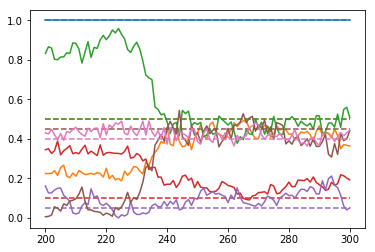



[T] -> [T] * [P] (0.44409726895)
[T] -> [T] + [P] (0.19245405669)
[T] -> [P] (0.363448674359)
[E] -> [T] (0.507857155456)
[E] -> [E] * [T] (0.0507401134697)
[E] -> [E] + [T] (0.441402731074)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [62]:
new_G, alphas, _ = gibs_sample(300, G, corpus2, alpha=1, alpha_udpate_frac=1, plot_len=100)
print '\n'
print new_G
print '\n'
print G

Another 300 step run on corpus2 now gives us some other results...

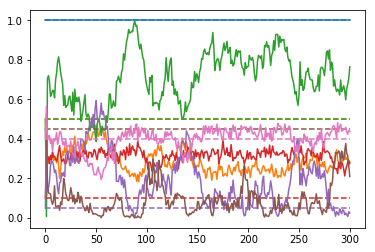



[T] -> [P] (0.284715204443)
[T] -> [T] + [P] (0.276637155493)
[T] -> [T] * [P] (0.438647640064)
[E] -> [T] (0.764449941408)
[E] -> [E] + [T] (0.210350087178)
[E] -> [E] * [T] (0.025199971414)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [88]:
new_G, alphas, samples_dict_corpus2 = gibs_sample(300, G, corpus2, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

## Runs of 600 samples

On corpus1, plotting sample-paths between 300 and 600. Since corpus1 is really small (10 sentences) the sample-paths are very jagged - they show really large deviations. Hence the samples will have large variance.

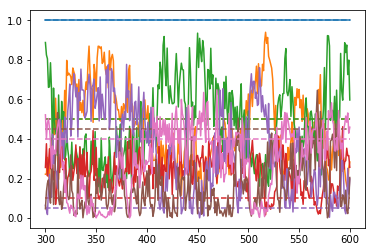



[T] -> [P] (0.283680047493)
[T] -> [T] + [P] (0.256879824041)
[T] -> [T] * [P] (0.459440128466)
[E] -> [T] (0.597016701997)
[E] -> [E] + [T] (0.205191563979)
[E] -> [E] * [T] (0.197791734023)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [ ]:
new_G, alphas,  samples_dict_corpus1 = gibs_sample(600, G, corpus1, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

Let's also make some histograms of the samples! Below we making a histogram of samples between 300 and 600 with lag 20:

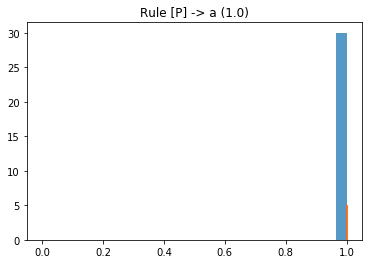

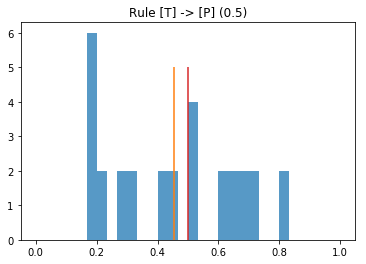

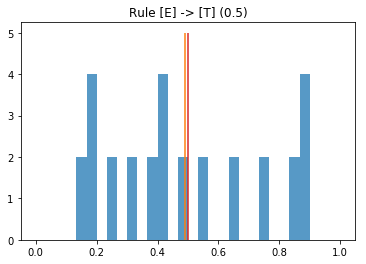

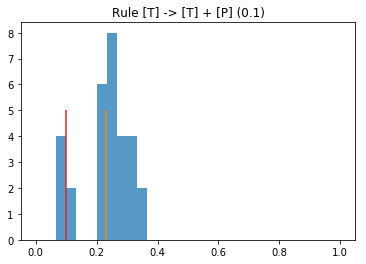

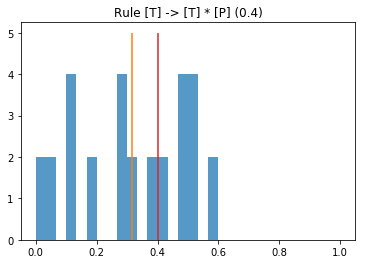

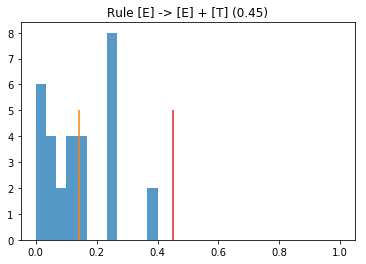

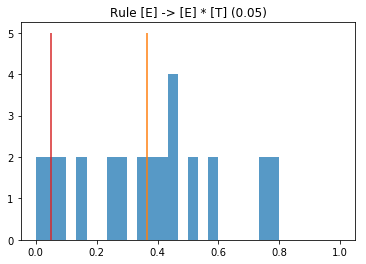

In [136]:
lag_samples_dict_corpus1 = {}
for k, v in samples_dict_corpus1.iteritems():
    lag_samples_dict_corpus1[k] = [v[0]]+v[300:600:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus1)

On corpus2:

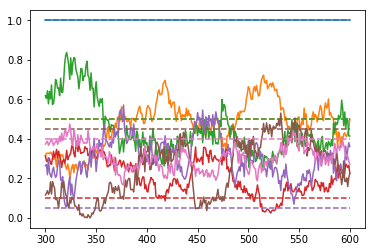



[T] -> [P] (0.500233746559)
[T] -> [T] + [P] (0.226787848673)
[T] -> [T] * [P] (0.272978404768)
[E] -> [T] (0.414469904274)
[E] -> [E] + [T] (0.224785298053)
[E] -> [E] * [T] (0.360744797673)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [103]:
new_G, alphas, samples_dict_corpus2 = gibs_sample(600, G, corpus2, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

Histogram:

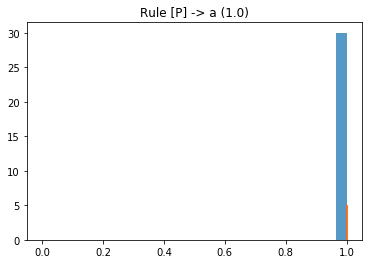

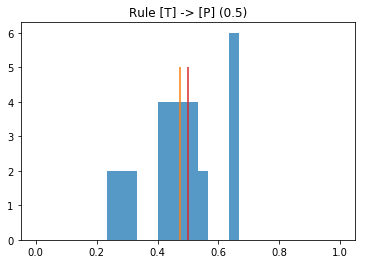

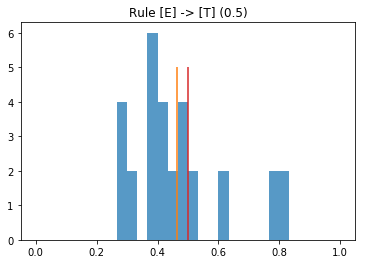

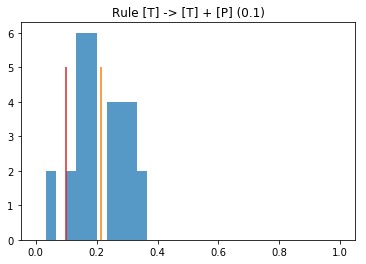

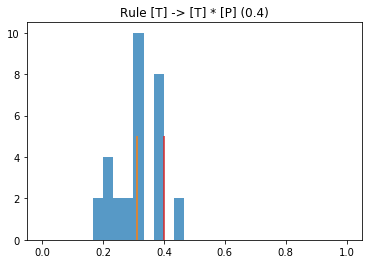

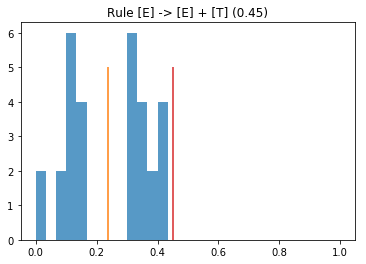

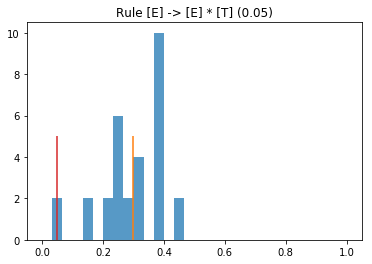

In [113]:
lag_samples_dict_corpus2 = {}
for k, v in samples_dict_corpus2.iteritems():
    lag_samples_dict_corpus2[k] = [v[0]]+v[300:600:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus2)

On corpus3:

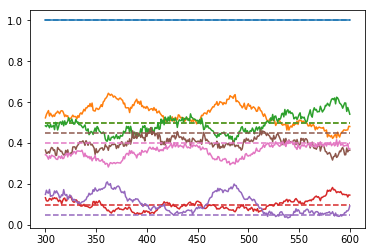



[T] -> [P] (0.481274620878)
[T] -> [T] + [P] (0.14609083242)
[T] -> [T] * [P] (0.372634546703)
[E] -> [T] (0.541265886829)
[E] -> [E] + [T] (0.365517463206)
[E] -> [E] * [T] (0.093216649965)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [90]:
new_G, alphas, samples_dict_corpus3 = gibs_sample(600, G, corpus3, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

Making a histogram. This run gives us samples really close to the 'true' parameter-setting.

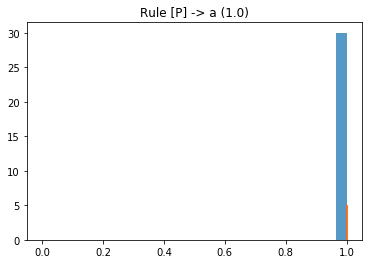

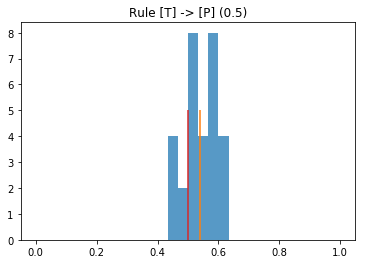

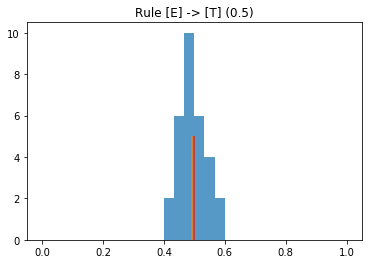

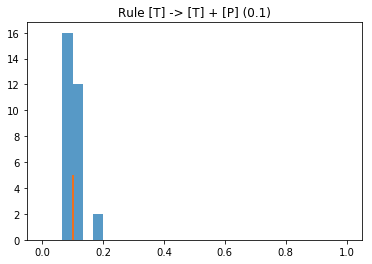

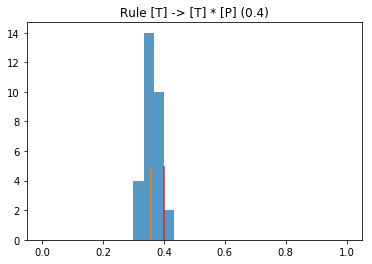

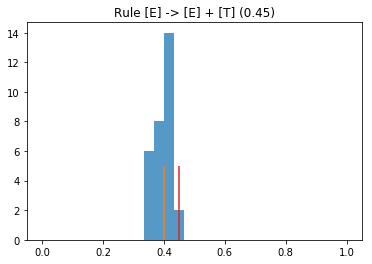

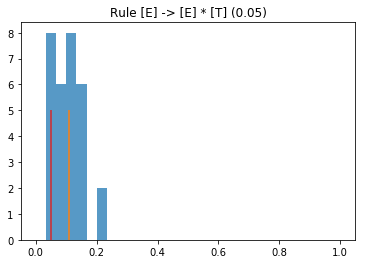

In [164]:
lag_samples_dict_corpus3 = {}
for k, v in samples_dict_corpus3.iteritems():
    lag_samples_dict_corpus3[k] = [v[0]]+v[300:600:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus3)

## Run of 1000 samples

Corpus 2:

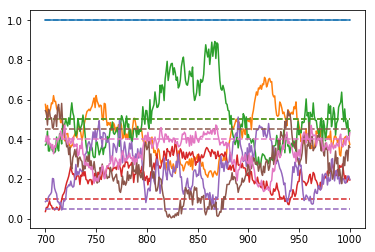



[T] -> [P] (0.373417164636)
[T] -> [T] + [P] (0.19434613967)
[T] -> [T] * [P] (0.432236695694)
[E] -> [T] (0.443864794012)
[E] -> [E] + [T] (0.359091707835)
[E] -> [E] * [T] (0.197043498153)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [117]:
new_G, alphas, samples_dict_corpus2_1000 = gibs_sample(1000, G, corpus2, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

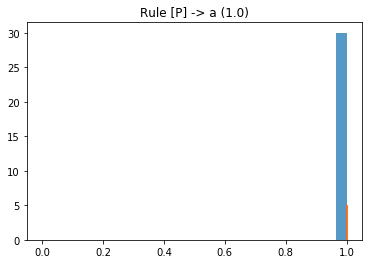

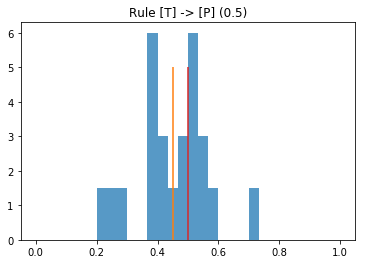

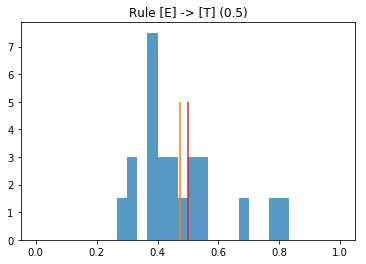

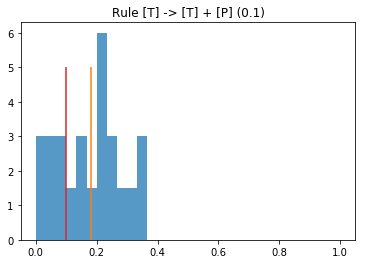

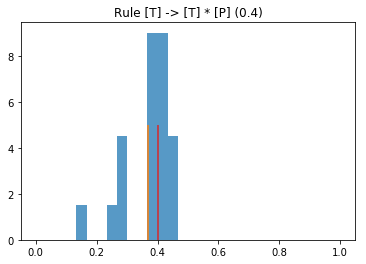

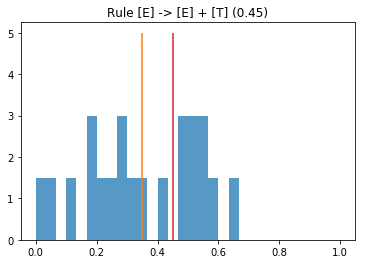

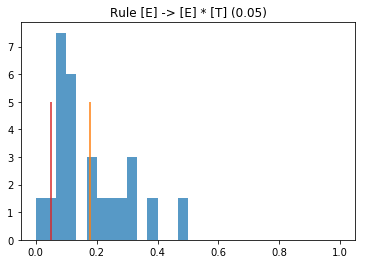

In [119]:
lag_samples_dict_corpus2_1000 = {}
for k, v in samples_dict_corpus2_1000.iteritems():
    lag_samples_dict_corpus2_1000[k] = [v[0]]+v[600:1000:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus2_1000)

Corpus 3:

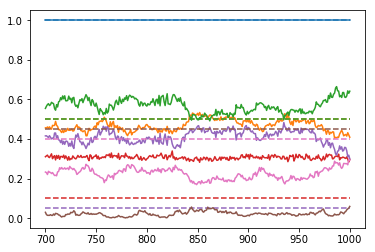



[T] -> [P] (0.408953364925)
[T] -> [T] + [P] (0.296966935698)
[T] -> [T] * [P] (0.294079699377)
[E] -> [T] (0.641506426078)
[E] -> [E] + [T] (0.0593391001287)
[E] -> [E] * [T] (0.299154473793)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [118]:
new_G, alphas, samples_dict_corpus3_1000 = gibs_sample(1000, G, corpus3, alpha=1, alpha_udpate_frac=1, plot_len=300)
print '\n'
print new_G
print '\n'
print G

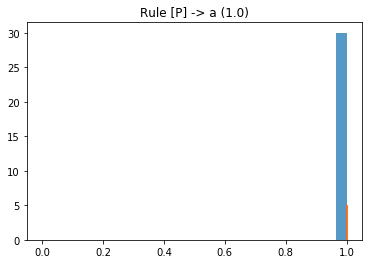

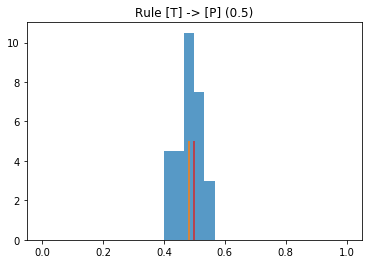

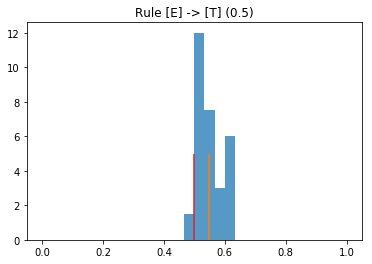

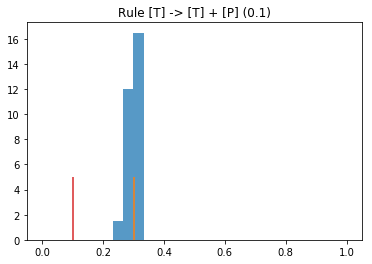

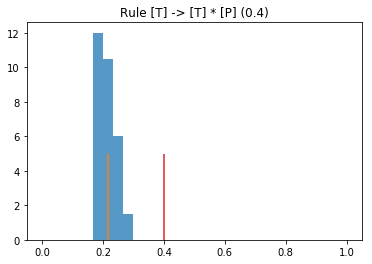

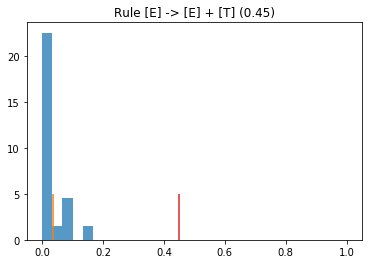

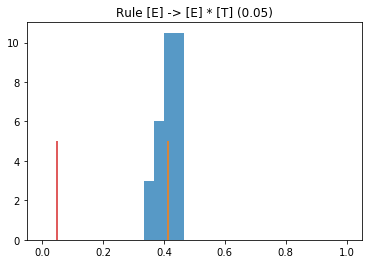

In [120]:
lag_samples_dict_corpus3_1000 = {}
for k, v in samples_dict_corpus3_1000.iteritems():
    lag_samples_dict_corpus3_1000[k] = [v[0]]+v[600:1000:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus3_1000)

## Runs of 2000 samples

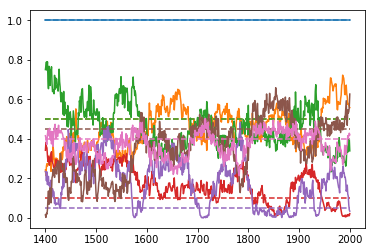



[T] -> [P] (0.557515014624)
[T] -> [T] + [P] (0.0218987271199)
[T] -> [T] * [P] (0.420586258256)
[E] -> [T] (0.339100785541)
[E] -> [E] + [T] (0.626645431086)
[E] -> [E] * [T] (0.0342537833734)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [122]:
new_G, alphas, samples_dict_corpus2_2000 = gibs_sample(2000, G, corpus2, alpha=1, alpha_udpate_frac=1, plot_len=600)
print '\n'
print new_G
print '\n'
print G

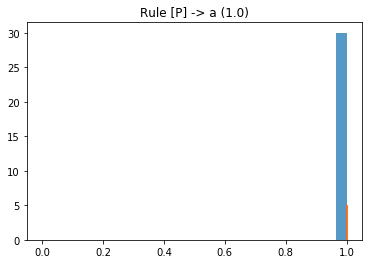

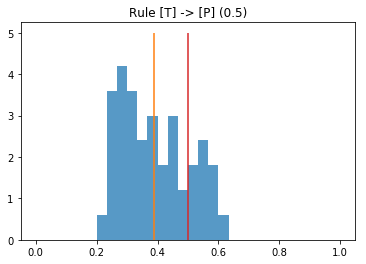

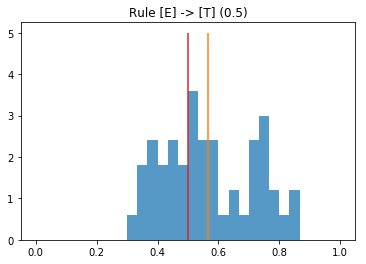

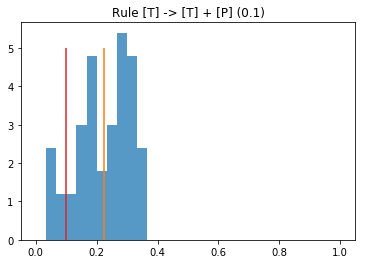

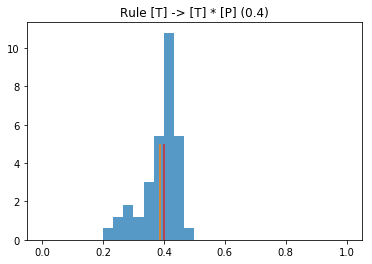

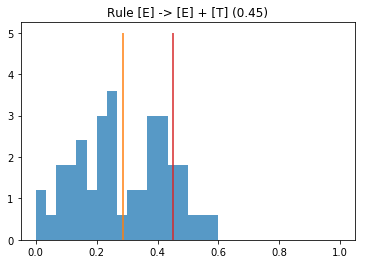

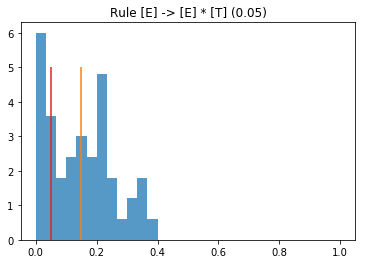

In [135]:
lag_samples_dict_corpus2_2000 = {}
for k, v in samples_dict_corpus2_2000.iteritems():
    lag_samples_dict_corpus2_2000[k] = [v[0]]+v[1000:2000:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus2_2000)

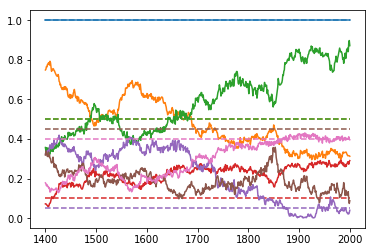



[T] -> [P] (0.312986828541)
[T] -> [T] + [P] (0.290766659253)
[T] -> [T] * [P] (0.396246512207)
[E] -> [T] (0.871803428105)
[E] -> [E] + [T] (0.0880660288373)
[E] -> [E] * [T] (0.0401305430572)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [123]:
new_G, alphas, samples_dict_corpus3_2000 = gibs_sample(2000, G, corpus3, alpha=1, alpha_udpate_frac=1, plot_len=600)
print '\n'
print new_G
print '\n'
print G

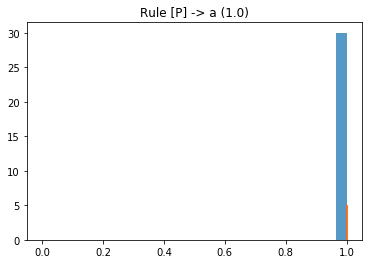

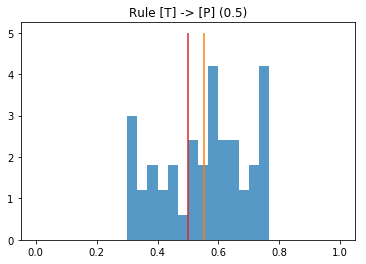

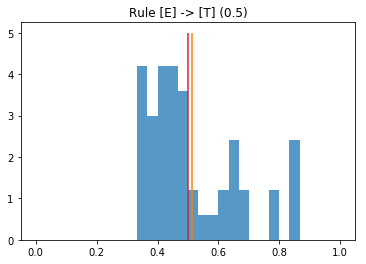

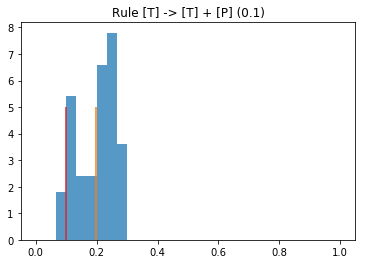

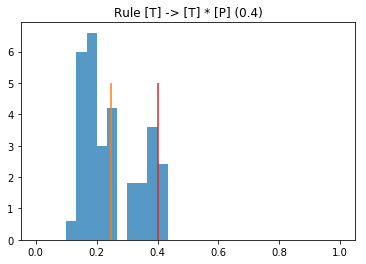

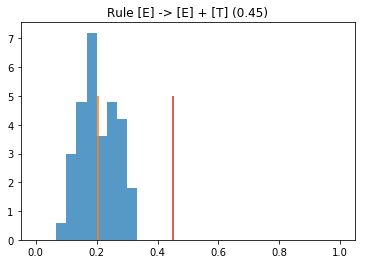

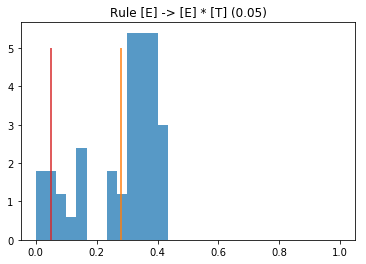

In [134]:
lag_samples_dict_corpus3_2000 = {}
for k, v in samples_dict_corpus3_2000.iteritems():
    lag_samples_dict_corpus3_2000[k] = [v[0]]+v[1000:2000:20] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus3_2000)

## Comparing sample runs on corpus3

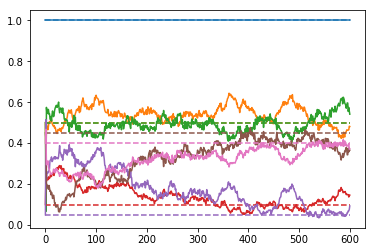

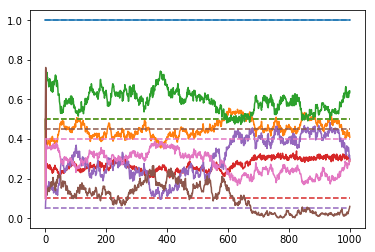

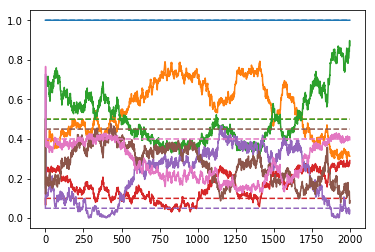

In [145]:
plot_gibs(samples_dict_corpus3, plot_len=600)
plot_gibs(samples_dict_corpus3_1000, plot_len=1000)
plot_gibs(samples_dict_corpus3_2000, plot_len=2000)

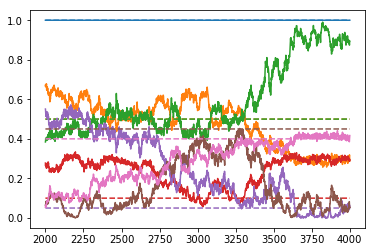



[T] -> [P] (0.289088919586)
[T] -> [T] + [P] (0.294320107038)
[T] -> [T] * [P] (0.416590973377)
[E] -> [T] (0.894397130629)
[E] -> [E] + [T] (0.0533096520845)
[E] -> [E] * [T] (0.0522932172869)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)


In [165]:
new_G, alphas, samples_dict_corpus3_4000 = gibs_sample(4000, G, corpus3, alpha=1, alpha_udpate_frac=1, plot_len=2000)
print '\n'
print new_G
print '\n'
print G

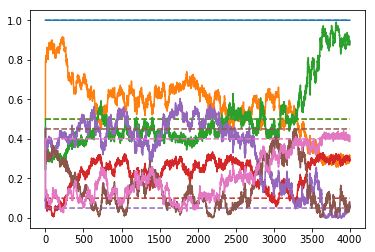

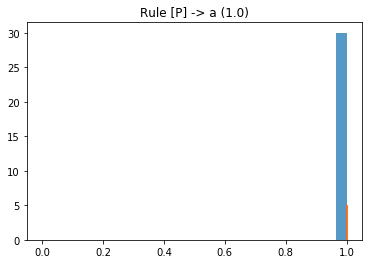

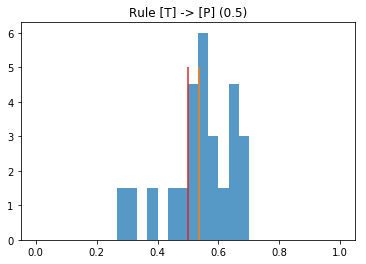

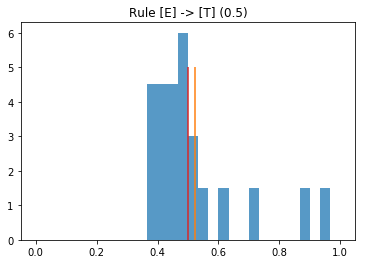

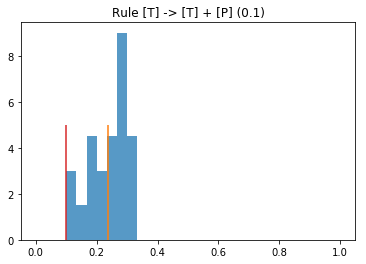

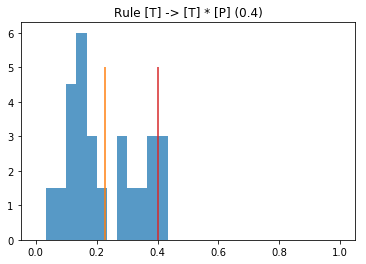

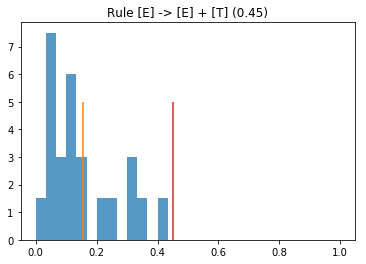

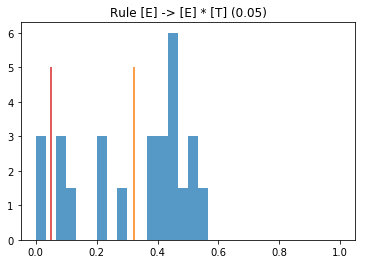

In [173]:
plot_gibs( samples_dict_corpus3_4000, plot_len=4000)

lag_samples_dict_corpus3_4000 = {}
for k, v in samples_dict_corpus3_4000.iteritems():
    lag_samples_dict_corpus3_4000[k] = [v[0]]+v[1000:4000:150] #first element in the sample path hold true probability!

gibs_sample_hist(lag_samples_dict_corpus3_4000)

## Metropolis-Hastings sampler

A metropolis-Hastings algorithm to sample directly from $p(\textbf{t}\mid\textbf{w}, \alpha)$, marginalizing over the production probabilities $\theta$. We follow Johnson et al. (2007).

$
p(t_i\mid \textbf{t}_{-i}, \alpha) = \displaystyle\prod_{A\in N} \frac{C(\alpha_A + \textbf{f}_A(\textbf{t}))}{C(\alpha_A + \textbf{f}_A(\textbf{t}_{-i})}
$ can easily be computed from the trees $\textbf{t}$. Given in function $marginal\_ti$.

$p(t_i\mid w_i, \theta)$ is sampled from$-$and computed$-$using ancestral sampling, as in the Gibs sampler. Given in function $make\_samples\_joint$.

$\theta_r^{'} = \displaystyle\frac{f_{r}(\textbf{t}_{-i}) + \alpha_r}{\sum_{r^{'} \in R_A}f_{r^{'}}(\textbf{t}_{-i}) + \alpha_{r^{'}}}$ is computed to update the thetas at each step. Given in function $compute\_theta$.

The acceptance probability of a new parse $t_i^{'}$ given the old parse $t_i$ for $w_i$ is given by the transition probability:
$$A(t_i,t_i^{'}) = \min\Bigg\{1, \frac{p(t_i^{'}\mid \textbf{t}_{-i}, \alpha)p(t_i\mid w_i, \theta^{'})}{p(t_i\mid \textbf{t}_{-i}, \alpha)p(t_i^{'}\mid w_i, \theta^{'})} \Bigg\}$$

Helper functions:

In [505]:
from scipy.special import gamma
from random import randint

def joint_probability(d):
    prob = 1.0
    for rule in d:
        prob *= rule.prob
    return prob

def make_samples_joint(grammar, corpus):
    '''
    Sample from p(t_i|w_i, theta)
    Note: grammar holds the thetas; corpus holds the w_i's
    :returns: list with (tree, tree-joint-prob)-tuples
    '''
    samples = []
    for sentence in corpus:
        goal = make_symbol('[E]', 0, len(sentence))
        forest = cky(grammar, sentence)
        I = inside(forest, goal)
        sample = ancestral_sample(forest, I, goal)
        joint_prob = joint_probability(sample)/I[goal]
        samples.append((sample, joint_prob))
    return samples


def compute_theta(grammar, trees, i, alphas):
    """
    Compute theta
    :param trees: holds all (tree, tree-joint-prob) pairs
    :param i: index of tree_i
    """
    # instantiate theta dictionary:
    thetas = defaultdict()
    for A in grammar.nonterminals:
        thetas[A] = {rule: 0 for rule in grammar.get(A)}
    
    # collect counts
    for A in grammar.nonterminals:
        for rule in grammar.get(A):
            # see explanation for function of alpha_udpate_frac
            tree_counts = 0
            for tree, _ in trees[:i]+trees[i+1:]:
                tree_counts += len(get_instances(rule, tree))
            thetas[A][rule] += tree_counts + alphas[A][rule]

    # normalize
    for A in grammar.nonterminals:
        total = float(sum(thetas[A].values()))
        for rule in grammar.get(A):
            thetas[A][rule] *= 1/total
    
    return thetas

def marginal_ti(tree_i, trees, alphas):
    """
    :param tree_i: holds (tree_i, tree_i-joint-prob)
    :param trees: holds all (tree, tree-joint-prob) pairs except for tree_i
    """
    def C(alpha):
        return np.prod(gamma(alpha))/gamma(np.sum(alpha))
    
    prob = 1
    # recall that alphas holds all the rules of the grammar
    for A in alphas:
        ft = []
        ft_i = []
        for rule in alphas[A]:
            alpha_r = alphas[A][rule]
            ft.append(alpha_r)
            ft_i.append(alpha_r)

            for tree, _ in trees:
                instances = len(get_instances(rule, tree))
                ft[-1] += instances
                ft_i[-1] += instances
            # ft also counts occurences    
            ft[-1] += len(get_instances(rule, tree_i[0]))

        prob *= C(ft)/C(ft_i)
    return prob

The sampler:

In [511]:
def MH_sample(n, grammar, corpus, alphas):
    
    samples = []
    
    # initalize with some random trees
    grammar = initialize(grammar) # initalize gives Dirichlet sample probs to rules
    alphas = {A: {R: 1 for R in grammar.get(A)} for A in grammar.nonterminals}
    trees = make_samples_joint(grammar, corpus)
    
    # we default start with the first tree
    i = 0
    
    for k in range(n):
        # keeping track of progress:
        if k%100 == 0:    
            print k
        old_tree_i = trees[i] # note: this is a tuple! joint returns (tree, prob)-tuples
        
        # compute theta'_r for each rule r leaving out old_tree_i
        thetas = compute_theta(grammar, trees, i, alphas)
        
        # sample t'_i
        new_grammar = update_grammar(grammar, thetas)
        new_tree_i = make_samples_joint(new_grammar, [corpus[i]])[0] # note: this is a tuple!
        
        # compute marginals
        trees_minus_i = [tree for j, tree in enumerate(trees) if j!=i]
        old_marginal = marginal_ti(old_tree_i, trees_minus_i, alphas)
        new_marginal = marginal_ti(new_tree_i, trees_minus_i, alphas)
        
        # compute proposal
        old_proposal = old_tree_i[1]
        new_proposal = new_tree_i[1]
        
        # accept t'_i with probability A
        A = min(1., (new_marginal*old_proposal)/(old_marginal*new_proposal))
        if np.random.uniform(0,1) < A:
            trees[i] = new_tree_i
#             print "Accepted"   # happens too often! 
        else:
            print "Not accepted"
        
        # save sample
        samples.append(trees[i][0])
        
        # randomly select new tree
        i = randint(0,len(corpus)-1)
    
    return samples

### Corpus 2

In [488]:
alphas = {A: {R: 1 for R in G.get(A)} for A in G.nonterminals}
corpus2_samples = MH_sample(10000, G, corpus2, alphas)

0


/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in double_scalars


100
200
300
400


/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in double_scalars


500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
1000


### Corpus 1

In [450]:
alphas = {A: {R: 1 for R in G.get(A)} for A in G.nonterminals}
trees, corpus1_samples = MH_sample(2000, G, corpus1, alphas)

0
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
100
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
200
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
300
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
400
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
500
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not accepted
Not

## Bayes estimator of $\theta$

Now that we have a set of samples from the posterior distribution $p(\textbf{t}\mid\textbf{w}, \alpha)$, we can for example compute the Bayes estimator $\hat{\theta} =\mathbb{E}_{p}[\Theta\mid\textbf{t},\textbf{w}]$ from the samples.

In [465]:
def estimate(grammar, trees):
    """
    Returns the Bayes estimate for theta_r for each rule r
    in the grammar based on the data in trees
    """
    ML_grammar = WCFG()
    
    counts = {A: {R: 0. for R in grammar.get(A)} for A in grammar.nonterminals}
    totals = defaultdict(float)

    # gather counts
    for A in grammar.nonterminals:
        for tree in trees:
            for rule in grammar.get(A):
                counts[A][rule] += len(get_instances(rule, tree))
        totals[A] = sum(counts[A].values())
    
    # normalize
    for A in grammar.nonterminals:
        for rule in grammar.get(A):
                ML_grammar.add(Rule(rule.lhs, rule.rhs, counts[A][rule]/totals[A]))

    return ML_grammar

def estimate_hist(grammar, trees):
    """
    Returns the Bayes estimate for theta_r for each rule r
    in the grammar based on the data in trees
    """
#     ML_grammar = WCFG()
    
    counts = {A: {R: [] for R in grammar.get(A)} for A in grammar.nonterminals}
    totals = defaultdict(float)

    # gather counts
    for A in grammar.nonterminals:
        for tree in trees:
            for rule in grammar.get(A):
                counts[A][rule].add(len(get_instances(rule, tree)))
        totals[A] = sum(counts[A].values())
    
    # normalize
    for A in grammar.nonterminals:
        for rule in grammar.get(A):
                ML_grammar.add(Rule(rule.lhs, rule.rhs, counts[A][rule]/totals[A]))

    return ML_grammar


In [1]:
burn_in = 500
lag = 20

lag_samples = samples[burn_in::lag] #discard first 500 samples, then collect samples with lag 20
print len(lag_samples)

estimated_grammar = estimate(G, samples)
print estimated_grammar
print G

NameError: name 'samples' is not defined

In [510]:
burn_in = 1000
lag = 100

print len(samples_corpus2[1])
lag_samples = samples_corpus2[1][burn_in::lag]
print len(lag_samples)

estimated_grammar = estimate(G, lag_samples)
print estimated_grammar
print '\n'
print G

10000
90
[T] -> [P] (0.378048780488)
[T] -> [T] * [P] (0.360975609756)
[T] -> [T] + [P] (0.260975609756)
[E] -> [T] (0.58064516129)
[E] -> [E] + [T] (0.245161290323)
[E] -> [E] * [T] (0.174193548387)
[P] -> a (1.0)


[T] -> [P] (0.5)
[T] -> [T] * [P] (0.4)
[T] -> [T] + [P] (0.1)
[E] -> [T] (0.5)
[E] -> [E] + [T] (0.45)
[E] -> [E] * [T] (0.05)
[P] -> a (1.0)
